# Class 5: Regression Analysis

<hr>

## Table of Contents

* [1 Exploratary Data Analysis](#chapter1)
    * [1.1 Data Understanding](#section_1_1)
    * [1.2 Data Collection ](#section_1_2)
* [2 Data Preparation](#chapter2)
    * [2.1 Data Cleaning](#section_2_1)
    * [2.2 Data Statistics](#section_2_2)
* [3 Data Visualization](#chapter3)
    * [3.1 Univariate Visualizations](#section_3_1)
    * [3.2 Data Relationships](#section_3_2)
* [4 Training the Model](#chapter4)
    * [4.1 Linear Regression](#section_4_1)
    * [4.2 Multiple Linear Regression](#section_4_2)
    * [4.3 Linear Regression using statsmodels](#section_4_3)
* [5 Model Evaluation with Visualizations](#chapter5)
    * [5.1 Regression Plot](#section_5_1)
    * [5.2 Residual Plot](#section_5_2)
    * [5.3 Distribution Plot](#section_5_3)
    
---

## 0 About the Dataset

The dataset is parsed data from the website which contains all of the ads of light vehicles for 7 major cities of Kazakhstan in June month of 2020. It containt over 55k ads across 10 variables such as car brand, price, year of manufacturing, engine size, color, wheel placement, transmission, type of base, and the link to original ad (might not be actual).


## 1 Exploratory Data Analysis <a class="anchor" id="chapter1"></a>

### 1.1 Data Understanding <a class="anchor" id="section_1_1"></a>

Originally this data was collected for the purpose of comparing how the car sales market changed prior to quarantine and after quarantine has been introduced. In this case we will look at the data that has been collected during quarantine and we’ll predict what affects the price of a car.

**Exhibit 1: Variable Description** <a class="anchor" id="exhibit1"></a>
* **car** - vehicle brand and model
* **price** - listed price of a vehicle
* **city** - city in Kazakhstan where vehicle is advertised
* **year** - year of manufacture
* **base** - base shape (sedan, minivan, offroad, etc.)
* **engine** - engine volume in liters
* **gas** - type of fuel vehicle runs on (benzine, gas, gas-benzine, electrical, etc.)
* **transmission** - type of transmission
* **wheel** - steering wheel position (left, right
* **color** - color of the vahicle
* **url** - url to original ad (may be outdated)

We can classify the various data columns into numerical/categorical attributes:
1. Numerical Attributes: price, year, engine
2. Categorical Attributes: car, city, base, gas, transmission, wheel, color

<hr>

### 1.2 Data Collection  <a class="anchor" id="section_1_2"></a>
In this particular case this step has been already been done. The data was parsed from web pages of advertisements from 7 major cities (regional centers) of Kazakhstan. The data for each city is on different file, however, and we want to have them them all standartized and merged into a single CSV file. 

#### Read multiple files into a list of dataframes
There several mothods of reading multiple files. Here, we will use `glob` library preliminarily making sure the file names are consistent. 

In [14]:
import pandas as pd
import numpy as np
from glob import glob

filenames = glob('*COVID-19_clean.csv')
dataframes = [pd.read_csv(f, sep=';') for f in filenames]

print(len(dataframes), " files have been loaded")

7  files have been loaded


#### Join dataframes in list (data from 7 cities)
To be able to join vertically the file structures must be identical. This can be verified by opening and exploring each file. Excel is more convininet here.

Then perform vertical concatenation and set `ignore_index` parameter to `True` so that the resulting axis will be labeled `0, …, n - 1`.

In [15]:
data = pd.concat(dataframes, ignore_index=True)
data.head()

,car,price,city,year,base,engine,gas,transmission,wheel,color,url
0,Volkswagen Passat,3 600 000,Актобе,2009,седан,2.0,бензин,КПП автомат,левый руль,серый,https://kolesa.kz//a/show/105704616
1,Land Rover Range Rover Sport,12 000 000,Актобе,2011,внедорожник,5.0,бензин,КПП автомат,левый руль,черный,https://kolesa.kz//a/show/97067436
2,Hyundai Accent,4 700 000,Актобе,2014,хэтчбек,1.6,газ-бензин,КПП типтроник,левый руль,белый,https://kolesa.kz//a/show/105254082
3,Infiniti QX80,27 999 000,Актобе,2019,внедорожник,5.6,бензин,КПП автомат,левый руль,белый,https://kolesa.kz//a/show/104433343
4,Kia Sorento,2 800 000,Актобе,2004,внедорожник,2.5,дизель,КПП автомат,левый руль,серебристый,https://kolesa.kz//a/show/105659979


In [16]:
print("There are", data.shape[0], "rows, and", data.shape[1], "columns in the dataset.")

There are 55977 rows, and 11 columns in the dataset.


<hr>

## 2 Data Preparation <a class="anchor" id="chapter2"></a>

Now you can perform the steps to clean the data.

### 2.1 Data Cleaning <a class="anchor" id="section_2_1"></a>

Since we are merging multiple files it is a good idea to verify each column for data consistency and range of values. 

**Common data problems**
* Data type constraints: `price` and `engine` are not numeric, we will convert using `pd.numeric()`
* There more problems with `engine` column. Since it contains data from several files, it has values of different type (numeric and text). At some rows, the values are with units ("3 л"), in other places it just says "электрич" for electric engines. Such inconsistencies are better handled in Excel if dataset size permits (which I did).
* `url` column is of no use for analysis, we will drop it.
* `price`s are represented with thousand separators, we will remove the spaces and convert the columns into continuous number.

**Text and categorical data problems**
* Quick check of values of each column revealed that there are leading spaces on columns `wheel`, `base`, `gas`, `transmission`, `color`. 
* Using the `unique()` function we check categorical columns if the values has any inconsistencies. This step better to be done after `strip`ping the columns of leading and trailing spaces.
* Split the `car` column into two separate columns: `brand` and `model`. This way we can leverage brand information in our model.
* The wheel column has only two possible values: `левый руль` and `правый руль`. Let's represent it as 0 and 1 respectively. Note: some files represented `левый руль` (default) as an empty space or NaN.


In [17]:
# Drop the url as it is of no use.
data.drop('url', axis = 1, inplace = True)

# Strip off empty spaces and convert to numeric
data.price = data.price.astype(str).str.replace(' ', '')

# Convert columns "price" and "engine"
data[['price', 'engine']] = data[['price', 'engine']].apply(pd.to_numeric)

# To remove space from the beginning of a string (leading spaces)
cols =  ['base', 'gas', 'transmission',  'wheel',  'color']
for col in cols:
    data[col] = data[col].str.lstrip()

# Transform wheel column to binary numeric
data.wheel.replace(['левый руль', "", np.nan, 'правый руль'], [0, 0, 0, 1],  inplace=True)
data.rename(columns = {'wheel':'wheel_right'})

data.dtypes

car              object
price             int64
city             object
year              int64
base             object
engine          float64
gas              object
transmission     object
wheel             int64
color            object
dtype: object

In [18]:
data.head()

,car,price,city,year,base,engine,gas,transmission,wheel,color
0,Volkswagen Passat,3600000,Актобе,2009,седан,2.0,бензин,КПП автомат,0,серый
1,Land Rover Range Rover Sport,12000000,Актобе,2011,внедорожник,5.0,бензин,КПП автомат,0,черный
2,Hyundai Accent,4700000,Актобе,2014,хэтчбек,1.6,газ-бензин,КПП типтроник,0,белый
3,Infiniti QX80,27999000,Актобе,2019,внедорожник,5.6,бензин,КПП автомат,0,белый
4,Kia Sorento,2800000,Актобе,2004,внедорожник,2.5,дизель,КПП автомат,0,серебристый


There are a few other things we need to check for data quality:
* Missing Values: Some ads do not fill certain information about the vehicle. We can deal with such missing values by either dropping them if they are not too many, imputing with average where appropriate, or in this particular case we find fill that information from variety of sources.
* Outliers: Some cars may have very high prices despite their general characteristics (special tuning, rare model, retro, etc.) Trainig your model with such values may give wrong results. It is a good practice to remove these outliers.
* Duplicate data: There may be some ads that are listed in several cities. We should drop the duplicate data, as it could lead to overfitting.

In [26]:
# Checking the missing values
data.isnull().sum()

car             0
price           0
city            0
year            0
base            0
engine          0
gas             0
transmission    0
wheel           0
color           0
dtype: int64

In [22]:
data[data.engine.isnull()]

,car,price,city,year,base,engine,gas,transmission,wheel,color
3212,Mitsubishi Galant,800000,Актобе,1996,седан,NaN,газ-бензин,КПП механика,0,зеленый
7749,Nissan Juke,4950000,Алматы,2013,седан,NaN,NaN,КПП автомат,0,нет цвета
7835,Daewoo Nexia,1790000,Алматы,2013,седан,NaN,NaN,КПП механика,0,нет цвета
11897,Toyota RAV 4,2000000,Алматы,1995,кроссовер,NaN,NaN,КПП автомат,1,черный
12459,Jaguar I-Pace,38000000,Алматы,2019,кроссовер,NaN,NaN,КПП вариатор,0,нет цвета
14741,Jaguar I-Pace,50208000,Алматы,2019,кроссовер,NaN,NaN,КПП вариатор,0,нет цвета
54345,ГАЗ ГАЗель,1300000,Шымкент,1997,пикап,NaN,газ-бензин,КПП механика,0,нет цвета


Do not rush dropping rows with missing values without understanding underlying causes. We are dealing with light vehicle engine volumes here. We have electrical vehicle in our dataset too (Teslas, BMW i3, Nissan Leaf, etc.). Therefore, where for those 17 rows missing engine volume, where `gas` == electric impute zeroes. For reference, there are 10 such rows.

The same applies to `gas` columns. For electric car models sometimes fuel type is left empty. To preserve such observations, let's impute `engine` and `gas` columns with `0` and `электричество` respectively, where `car` models have `Tesla` or `Nissan Leaf`. Note, all these steps can be done during initial cleaning in Excel for convinience.

In [21]:
# Filter the data to get electric vehicles and update engine volume to zero
#data[(data.engine.isnull()) & (data['gas'] == 'электричество')]
data.loc[(data.engine.isnull()) & (data['gas'] == 'электричество'), 'engine'] = 0

Usually ads are posted with picture of a car and I suppose this is the reason why so many ads are missing color information. There are over 4300 of such ads. While other missing rows with small count can be dropped, 4300 is too much. Therefore, the decision here is to impute the missing colors with the most frequent (and neutral) color `white`. 
(I wonder what `нет цвета` means? Is it "missing" value or undefined color. Let's leave it as it is for now) 

In [25]:
#data.color.value_counts()

# Find the mode of color in data
color_mode = data.color.mode()[0]

# Fill the missing values with mode value of month in data.
data.color.fillna(color_mode, inplace = True)

# Dropping the remaining records with missing values in dataframe.
data = data.dropna()

In [24]:
data.color.mode()[0]

'белый'

### 2.2 Data Statistics <a class="anchor" id="section_2_2"></a>

Descriptive statistics is a good step to start exploring numeric variables. It gives us such measure as min, max, mean, standard deviation, quartiles, etc. We can interpret them to see if there are any missing values, outliers, range of values and decide how to preprocess them before feeding into our model.


In [27]:
# Descriptive stats with applying some formatting for easy reading
with pd.option_context('float_format', '{:,.2f}'.format): 
    print(data.describe())

                 price      year    engine     wheel
count        55,967.00 55,967.00 55,967.00 55,967.00
mean      5,326,194.54  2,005.49      2.40      0.05
std      18,256,595.45      9.28      0.98      0.22
min          10,000.00  1,927.00      0.00      0.00
25%       1,600,000.00  1,997.00      1.60      0.00
50%       3,400,000.00  2,007.00      2.00      0.00
75%       6,000,000.00  2,013.00      2.80      0.00
max   4,000,000,000.00  2,020.00      9.90      1.00


>What?! ***4_000_000_000*** (4 billions of tenge)?!!! This is clearly an ***outlier***.

In [1]:
data[data.price >= 1_000_000_000]

NameError: name 'data' is not defined

## 3 Data Visualizations  <a class="anchor" id="chapter3"></a>

A brief reminder:
* Intended to allows us to understand our data more deeply
    * understanding breeds good decisions
    * fundamental communication tool
* Without data visualization and data analysis:
    * more prone to misunderstandings; and
    * more prone to miss opportunities
* Data Visualization is not producing a nice plot
    * integrated with domain expertise
    * can build on all other supervised and unsupervised tools
    * should be pervasive and enable action

Four pillars for visualization:
* purpose (the why)
* content (the what)
* structure (the how)
* formatting (everything else)

Keep in mind good practices to “tell a story”:
* communicate baseline
* handle viewer’s biases properly
* statistics is capable of summarizing information
    * **insight**: reduce data to a few very informative summary statistics, then visualize them.

### 3.1 Univariate Visualizations   <a class="anchor" id="section_3_1"></a>


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD61D8CC08>,
      dtype=object)

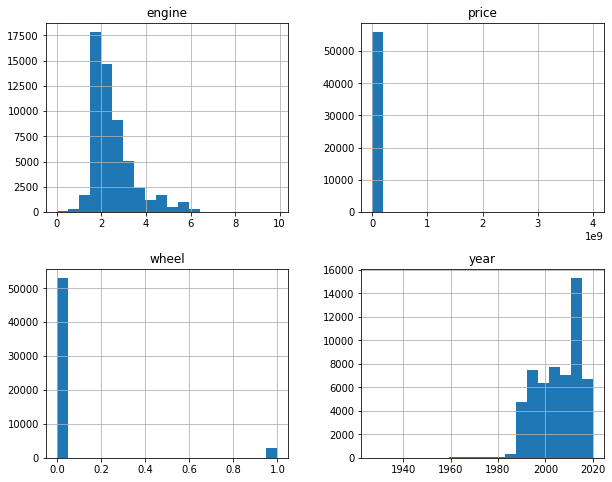

In [29]:
numeric_variables = data.select_dtypes(exclude=['object'])
numeric_variables.hist(figsize=(10,8), bins=20)

Due to the price of Lamborghini Diablo (4 billion tenge), the histogram of `price` column is not very informative. 
However on other three histograms we can start getting a few insights:
1.
2.
3. 

Now, for categorical variables, we will look at their frequency distributions. We will use count plot for this.

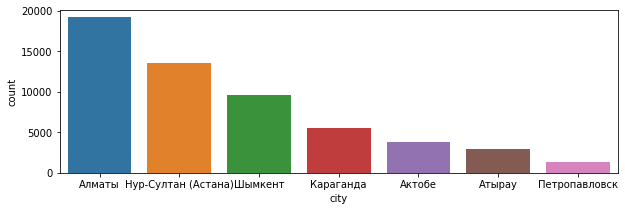

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# this allows plots to appear directly in the notebook
%matplotlib inline

categorical_variables = data.select_dtypes(include=['object'])

plt.figure(figsize=(10,3))
sns.countplot(data = categorical_variables, x='city', order=categorical_variables.city.value_counts().index)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 <a list of 18 Text xticklabel objects>)

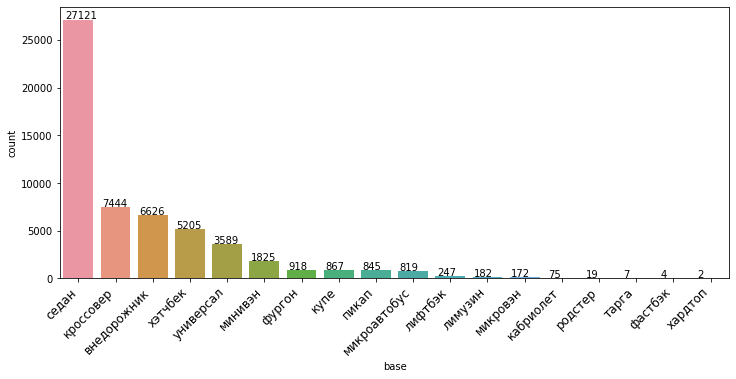

In [31]:
plt.figure(figsize=(12,5))
ax2 = sns.countplot(data = categorical_variables, x='base', order=categorical_variables.base.value_counts().index)

for p in ax2.patches:
        ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.04, p.get_height()+70))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)

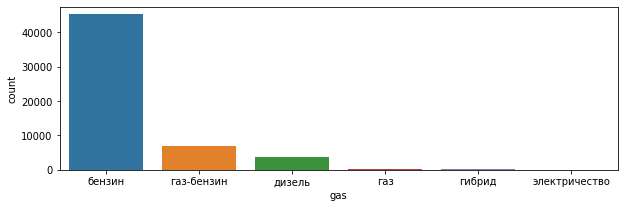

In [32]:
plt.figure(figsize=(10,3))
sns.countplot(data = categorical_variables, x='gas', orient='v')

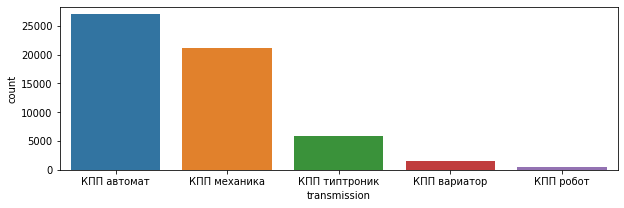

In [33]:
plt.figure(figsize=(10,3))
sns.countplot(data = categorical_variables, x='transmission', order=categorical_variables.transmission.value_counts().index)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text xticklabel objects>)

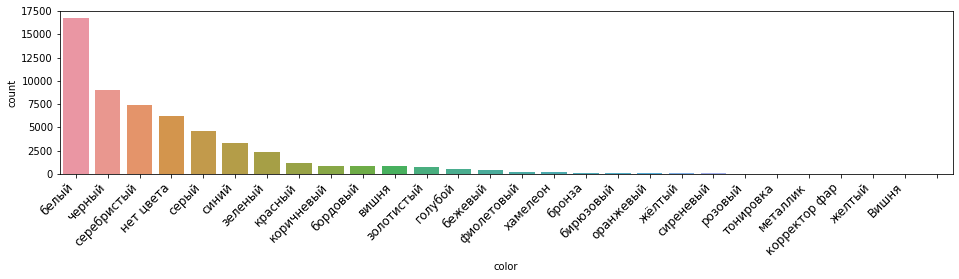

In [34]:
plt.figure(figsize=(16,3))
sns.countplot(data = categorical_variables, x='color', order=categorical_variables.color.value_counts().index)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)

### 3.2  Data Relationships   <a class="anchor" id="section_3_2"></a>

Let’s have a look at the relationship among various columns.

In [ ]:
# Compute the correlation matrix 
corr = data.corr()

# Setup the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

# Generate a custome diverging color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
_ = sns.heatmap(corr, cmap='YlGn', square=True, ax=ax, annot=True, linewidth=0.1)

plt.title('Pearson Correlation of Features', y=1.05, size=15)

In [ ]:
print(corr)

## 4 Training the Model <a class="anchor" id="chapter4"></a>

### 4.1 Linear Regression <a class="anchor" id="section_3_1"></a>

Simple linear regression is an approach for predicting a **quantitative response** using a **single feature** (or "predictor" or "input variable"). It takes the following form:

$y = \beta_0 + \beta_1x$

What does each term represent?
- $y$ is the response
- $x$ is the feature
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for x

Together, $\beta_0$ and $\beta_1$ are called the **model coefficients**. To create your model, you must "learn" the values of these coefficients. And once we've learned these coefficients, we can use the model to predict Sales!

Example using sklearn library:

In [36]:
from sklearn.linear_model import LinearRegression 

lm=LinearRegression()
X = data[['year']]
Y = data['price']

#fit the model, i.e. find the parameters b0 and b1
lm.fit(X, Y)

#obtain preditions
Yhat = lm.predict(X)

#you can view the intercept (b0):
print('Intercept: ', lm.intercept_)

#you can view the slope (b1):
print('Slope or coefficient of the feature (b1): ', lm.coef_[0])

Intercept:  -717793447.6584355
Slope or coefficient of the feature (b1):  360569.66061734396


The output doesn't make sense because we have too many outliers in the `target`. 

**The relationship between [b0 and b1] is given by:**
Price = -717,793,447.65 + 360,569.66 * X

### 4.2 Multiple Linear Regression <a class="anchor" id="section_4_2"></a>

Yhat = b0 + b1 * X1 + b2 * X2

* **High cardinality** - High cardinality means that most of the values in that dataset column are unique (e.g. `url` column). Low cardinality, on the other hand, means that many of these values in a dataset column are repeated (in our case `city`, `transmission`, `base`, `color`).
* **Multicollinearity** - refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related (Wikipedia).
* **Heteroskedasticity** - 

<br>
In order to start introducing other variables we need to do some feature engineering. Linear regression models take numeric variables as inputs. Our dataset has multiple categorical variable that we need to prepare first. We performed this step on `wheel` column above. Columns `base`, `gas`, `transmission`, and `color` are different - they have many categories (refer to frequency plot above). In order to transfor these nominal categorical variables to numeric we will apply a technique called *count/frequency encoding* - basically replacing a category with its frequency in that column. We won't go too much in detail here. 

`car` models column needs additional work which I did not cover in this exercise. Therefore, for now we will not include model information to our regression model.

In [37]:
# Let's see again how many categories each of these columns have
for col in categorical_variables.columns[2:]:
    print(col, ": ", len(categorical_variables[col].unique()), " labels")

base :  18  labels
gas :  6  labels
transmission :  5  labels
color :  28  labels


In [38]:
# Capture frequency values for each category
data.base.value_counts().to_dict()

{'седан': 27121,
 'кроссовер': 7444,
 'внедорожник': 6626,
 'хэтчбек': 5205,
 'универсал': 3589,
 'минивэн': 1825,
 'фургон': 918,
 'купе': 867,
 'пикап': 845,
 'микроавтобус': 819,
 'лифтбэк': 247,
 'лимузин': 182,
 'микровэн': 172,
 'кабриолет': 75,
 'родстер': 19,
 'тарга': 7,
 'фастбэк': 4,
 'хардтоп': 2}

In [39]:
frequency_map_base = data.base.value_counts().to_dict()
frequency_map_gas = data.gas.value_counts().to_dict()
frequency_map_transmission = data.transmission.value_counts().to_dict()
frequency_map_color = data.color.value_counts().to_dict()

data.base = data.base.map(frequency_map_base)
data.gas = data.gas.map(frequency_map_gas)
data.transmission = data.transmission.map(frequency_map_transmission)
data.color = data.color.map(frequency_map_color)

data.head()

,car,price,city,year,base,engine,gas,transmission,wheel,color
0,Volkswagen Passat,3600000,Актобе,2009,27121,2.0,45214,26974,0,4620
1,Land Rover Range Rover Sport,12000000,Актобе,2011,6626,5.0,45214,26974,0,9019
2,Hyundai Accent,4700000,Актобе,2014,5205,1.6,6808,5921,0,16697
3,Infiniti QX80,27999000,Актобе,2019,6626,5.6,45214,26974,0,16697
4,Kia Sorento,2800000,Актобе,2004,6626,2.5,3581,26974,0,7435


Now we are ready to feed these variables into our MLR model.

In [40]:
#extract and store predictor variables and store them as Z
Z = data[['year', 'base', 'engine', 'gas', 'transmission', 'wheel', 'color']]

#train the model
lm.fit(Z, data['price'])

#obtain preditions (array of arrays)
Yhat = lm.predict(Z)

#you can view the intercept (b0):
print('Intercept: ', lm.intercept_)

#you can view the slope array([b1, b2, b3, b4]):
print('Slopes / coefficients of the features (b1 to b7): ', lm.coef_)

Intercept:  -703104512.1035644
Slopes / coefficients of the features (b1 to b7):  [ 3.48855903e+05 -3.82349376e+01  3.46307669e+06  3.16468843e+01
 -1.02652018e+01  2.79911318e+05  1.24216416e+01]


In [41]:
Yhat

array([ 4847556.9197948 , 16772766.65090191,  5195261.87048948, ...,
       -3144134.13227332,  1209388.90618932, 13347678.41615331])

#### The estimated linear model:

**Price = **

<hr>

There is better of way representing model fitting results with **`statsmodels`** package.

### 4.3 Linear Regression using statsmodels  <a class="anchor" id="section_4_3"></a>

In [45]:
import statsmodels.api as sm

X = data[['year', 'base', 'engine', 'gas', 'transmission', 'wheel', 'color']]
y = data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X)

results = model.fit()
#results.params

# Full summary report
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     5977.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:38:26   Log-Likelihood:            -9.4542e+05
No. Observations:               55966   AIC:                         1.891e+06
Df Residuals:                   55958   BIC:                         1.891e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.859e+08   5.15e+06   -133.119   

In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     595.9
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:37:06   Log-Likelihood:            -1.0132e+06
No. Observations:               55967   AIC:                         2.026e+06
Df Residuals:                   55959   BIC:                         2.026e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.031e+08   1.73e+07    -40.680      0.000   -7.37e+08   -6.69e+08
year          3.489e+05   8623.724     40.453      0.000    3.32e+05    3.66e+05
base           -38.2349      6.939     -5.511      0.000     -51.834     -24.635
engine        3.463e+06   7.78e+04     44.489      0.000    3.31e+06    3.62e+06
gas             31.6469      4.881      6.484      0.000      22.081      41.213
transmission   -10.2652     10.125     -1.014      0.311     -30.111       9.580
wheel         2.799e+05    3.5e+05      0.800      0.424   -4.06e+05    9.65e+05
color           12.4216     13.765      0.902      0.367     -14.558      39.401
==============================================================================
Omnibus:                   276074.072   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    5025980389261.756
Skew:                         205.841   Prob(JB):                         0.00
Kurtosis:                   46425.970   Cond. No.                     1.14e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 5 Model Evaluation with Visualization <a class="anchor" id="chapter5"></a>

### 5.1 Regression Plot <a class="anchor" id="section_5_1"></a>

Regression plots are a good estimate of the relationship between two variables, the strength of the correlation, and the direction of the relationship (positive or negative). The horizontal axis is the independent variable. The vertical axis is the dependent variable. Each point represents a different target point. The fitted line represents the predicted value.

(0, 251089904.52821916)

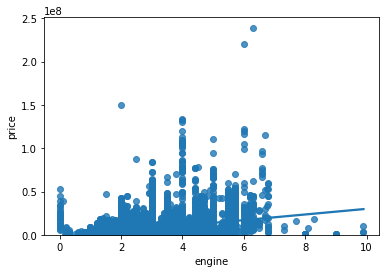

In [46]:
sns.regplot(x='engine', y='price', data=data)
plt.ylim(0,)

### 5.2 Resdiual Plot <a class="anchor" id="section_5_2"></a>
The residual plot represents the error between the actual value. Examining the predicted value and actual value we see a difference. We obtain that value by subtracting the predicted value, and the actual target value. We then plot that value on the vertical axis with the independent variable as the horizontal axis. Similarly, for the second sample, we repeat the process. Subtracting the target value from the predicted value. Then plotting the value accordingly. Looking at the plot gives us some insight into our data. We expect to see the results to have zero mean, distributed evenly around the x axis with similar variance. There is no curvature. This type of residual plot suggests a linear plot is appropriate.

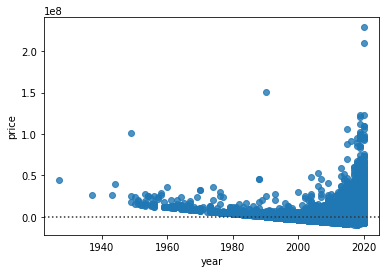

In [47]:
sns.residplot(data['year'], data['price'])

### 5.3 Distribution Plot <a class="anchor" id="section_3_3"></a>
A distribution plot counts the predicted value versus the actual value. These plots are extremely useful for visualizing models with more than one independent variable or feature.

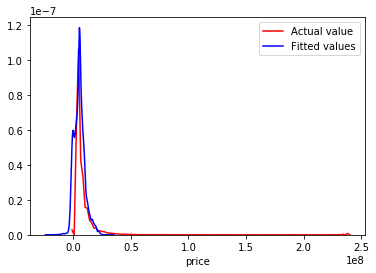

In [48]:
ax1 = sns.distplot(data['price'], hist=False, color='r', label='Actual value')
sns.distplot(Yhat, hist=False, color='b', label='Fitted values', ax=ax1)

<hr>
<hr>

### Improving predictive power

Improving predictive power of this model is not the purpose of this exercise. However, if you would like to experiment you can try following steps that we skipped as a starting idea.

* There are clearly many outliers. We left the outliers as is
* We did not check for duplicates 
* There are better ways of handling categorical variables other than *count/frequency encoding*
* Data transformation techniques
* Most importantly, we didn't fed the model with brand/make information. In my opinion, car brand should be the primary predictor.
* etc.

In [44]:
# Get indexes where name column has value john
indexNames = data[data['price'] >= 1_000_000_000].index
 
# Delete these row indexes from dataFrame
data.drop(indexNames , inplace=True)

In [ ]:
#data[data['price'] >= 1_000_000_000]

In [ ]:
# Duplicates
data_duplicates = data[data.duplicated(subset=None)]

In [ ]:
data_duplicates.sort_values(['car','price'])